In [49]:
import numpy as np
import pandas as pd

x_transforms = [lambda x: x, lambda x: np.log(x + 1)]
y_transforms = [
    lambda x: x,
    lambda x: np.log(x + 1),
    # lambda x: np.log(np.log(x + 1) + 1),
]

data = []
for i, x_transform in enumerate(x_transforms):
    for j, y_transform in enumerate(y_transforms):
        x = protests[weather_vars].applymap(x_transform)
        y = protests["size"].apply(y_transform)
        c = x.corrwith(y)
        data.append(dict(tx=i, ty=j, **c))

pd.DataFrame(data)

,tx,ty,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres
0,0,0,0.085350,0.087090,0.079564,-0.019740,-0.019682,0.028662,0.027844,-0.062519
1,0,1,0.090821,0.103708,0.079759,-0.018222,-0.086086,-0.007294,0.033315,-0.068915
2,1,0,0.089061,NaN,NaN,-0.024856,-0.025445,0.036018,0.028228,-0.062436
3,1,1,0.096631,NaN,NaN,-0.006547,-0.073064,0.000204,0.025890,-0.069023


The size variable is better `log`ged -- except for log(prcp)!

Whether the weather variables should be log-transformed is not so clear.

## Placebo tests

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

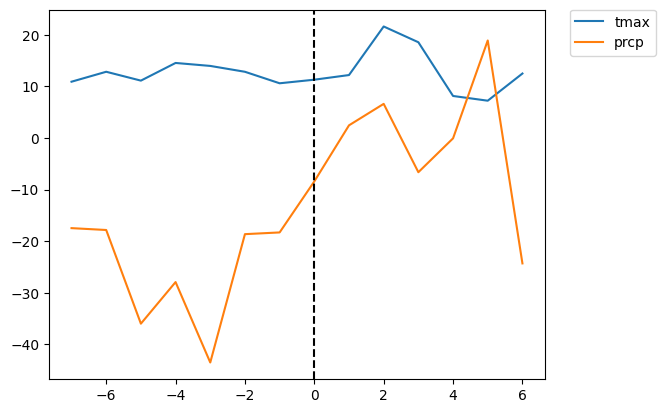

In [53]:
import statsmodels.api as sm

protests["avg_actor_size"] = protests.groupby("assoc_actor_1")["size"].transform("mean")
protests["avg_weekday_size"] = protests.groupby("weekday")["size"].transform("mean")
protests["avg_region_size"] = protests.groupby("admin1")["size"].transform("mean")
protests["avg_location_size"] = (
    protests.groupby("location")["size"].transform("mean") - protests["avg_region_size"]
)
protests["avg_actor_region_size"] = (
    protests.groupby(["assoc_actor_1", "admin1"])["size"].transform("mean")
    - protests["avg_region_size"]
)
protests["avg_actor_location_size"] = (
    protests.groupby(["assoc_actor_1", "location"])["size"].transform("mean")
    - protests["avg_location_size"]
)


def ols(a, b):
    df = protests[
        [
            a,
            b,
            "avg_actor_size",
            "avg_weekday_size",
            "avg_region_size",
            "avg_location_size",
            "avg_actor_region_size",
            "avg_actor_location_size",
        ]
    ]
    X, Y = df.drop(columns=[b]), df[b]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X)
    results = model.fit()
    return results.params[a]


plot_timeline(ols, "size")

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

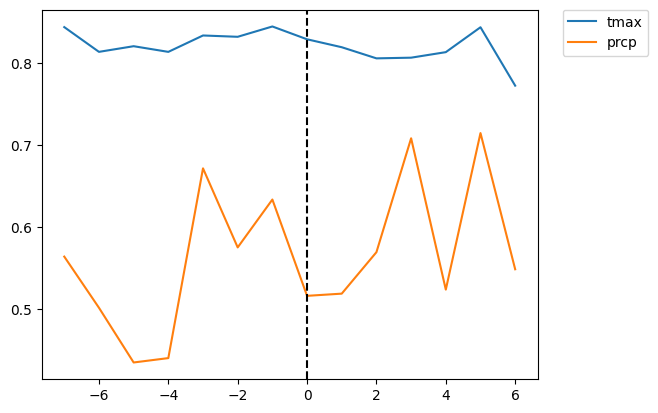

In [56]:
from functools import partial

from sklearn.ensemble import RandomForestRegressor


def rf(a, b, seed):
    df = protests[
        [
            a,
            b,
            "avg_actor_size",
            "avg_weekday_size",
            "avg_region_size",
            "avg_location_size",
            "avg_actor_region_size",
            "avg_actor_location_size",
        ]
    ]
    X, Y = df.drop(columns=[b]), df[b]
    model = RandomForestRegressor(random_state=seed)
    model.fit(X, Y)
    return model.score(X, Y)


def rf2(a, b, seed):
    df = protests[[a, b, "admin1", "location", "assoc_actor_1"]]
    dummy_vars = ["admin1", "location", "assoc_actor_1"]
    df = pd.concat(
        [df.drop(columns=dummy_vars), pd.get_dummies(df[dummy_vars])], axis=1
    )
    X, Y = df.drop(columns=[b]), df[b]
    model = RandomForestRegressor(random_state=seed)
    model.fit(X, Y)
    return model.score(X, Y)


plot_timeline(partial(rf2, seed=0), "size")

## Using protest occurrence as variable

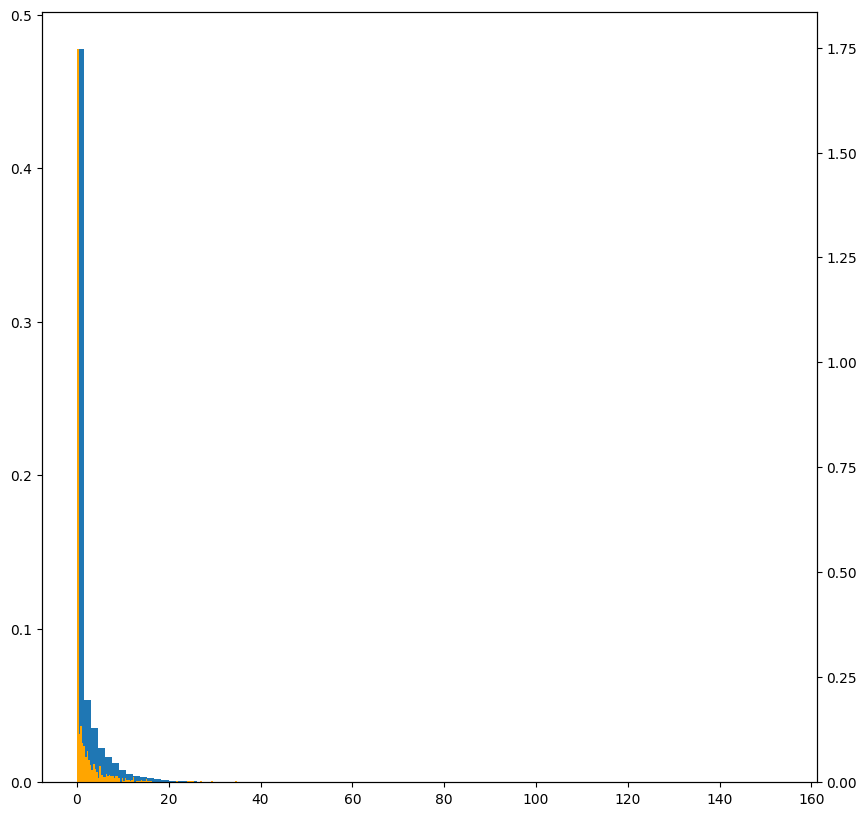

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(occurrence_df["prcp"], bins=100, density=True)
ax2 = ax.twinx()
ax2.hist(
    occurrence_df[occurrence_df["protest_count"] > 0]["prcp"],
    bins=100,
    density=True,
    color="orange",
)
plt.show()

Selecting a threshold:

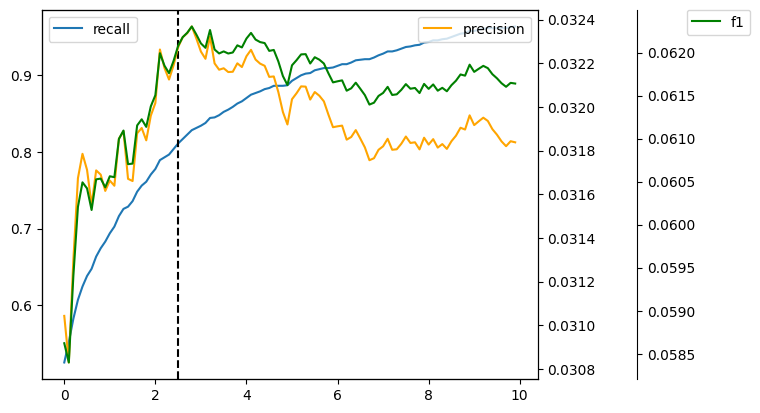

In [ ]:
metrics = []
for t in np.arange(0, 10, 0.1):
    matrix = np.array(
        [
            [
                occurrence_df.query(f"prcp > {t} & protest_count == 0").shape[0],
                occurrence_df.query(f"prcp > {t} & protest_count == 1").shape[0],
            ],
            [
                occurrence_df.query(f"prcp <= {t} & protest_count == 0").shape[0],
                occurrence_df.query(f"prcp <= {t} & protest_count == 1").shape[0],
            ],
        ]
    )
    recall = matrix[1, 1] / (matrix[1, 1] + matrix[0, 1])
    precision = matrix[1, 1] / (matrix[1, 1] + matrix[1, 0])
    f1 = 2 * (precision * recall) / (precision + recall)
    metrics.append(dict(t=t, matrix=matrix, recall=recall, precision=precision, f1=f1))
metrics = pd.DataFrame(metrics)

fig, ax = plt.subplots()
ax.plot(metrics.t, metrics.recall, label="recall")
ax2 = ax.twinx()
ax2.plot(metrics.t, metrics.precision, label="precision", color="orange")
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
ax3.plot(metrics.t, metrics.f1, label="f1", color="green")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
# position outside the axes
ax3.legend(bbox_to_anchor=(1.3, 1), loc="upper left", borderaxespad=0.0)
ax.axvline(2.5, color="black", linestyle="--")
plt.show()

prcp = 2.5 is indeed a good threshold.

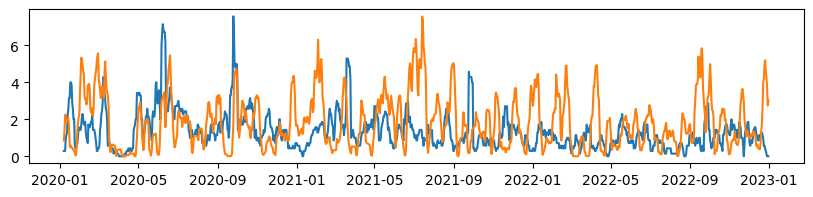

In [ ]:
by_date = occurrence_df.groupby("time").agg(
    {"protest_count": "sum", "protest_size": "sum", "prcp": "mean"}
)
plt.plot(by_date.index, by_date.protest_count.rolling(7).mean(), label="protest count")
plt.plot(by_date.index, by_date.prcp.rolling(7).mean(), label="protest count")
plt.gcf().set_size_inches(10, 2)

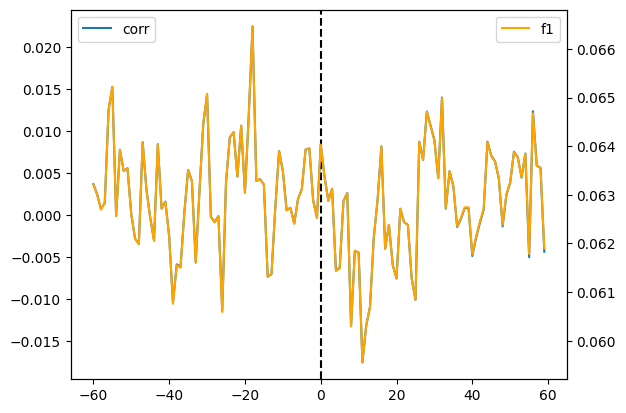

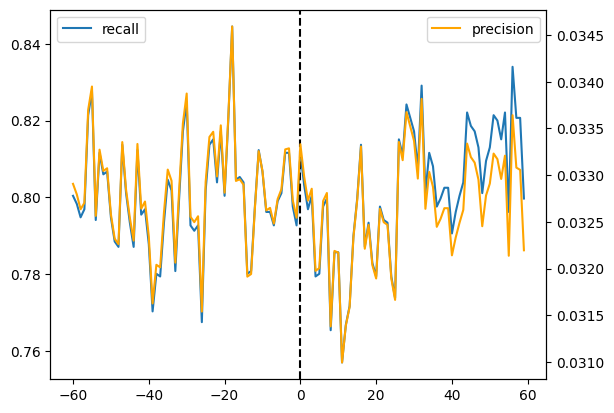

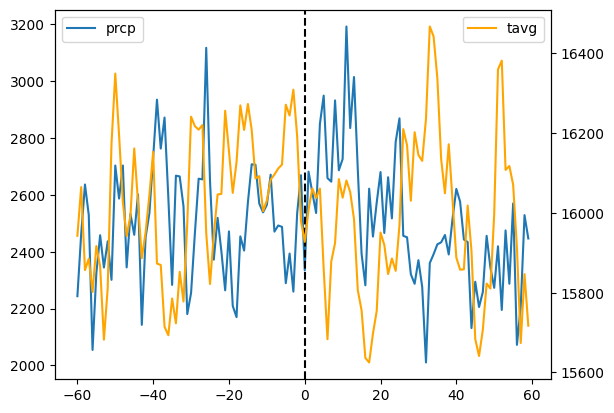

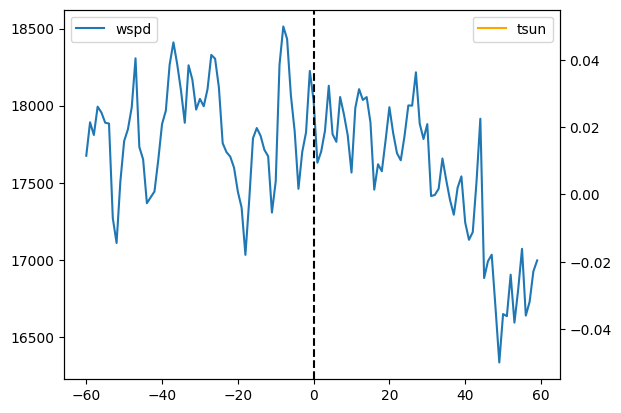

In [ ]:
def plot_props(df, p1, p2):
    fig, ax = plt.subplots()
    ax.plot(df.day, df[p1], label=p1)
    ax2 = ax.twinx()
    ax2.plot(df.day, df[p2], label=p2, color="orange")
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax.axvline(0, color="black", linestyle="--")
    plt.show()


plot_props(corrs, "corr", "f1")
plot_props(corrs, "recall", "precision")
plot_props(corrs, "prcp", "tavg")
plot_props(corrs, "wspd", "tsun")

## Climate protests

In [ ]:
# impute NaNs using random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0, estimator=RandomForestRegressor())
imp.fit(weather)
weather = pd.DataFrame(
    imp.transform(weather), columns=weather.columns, index=weather.index
)
weather.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,7.4,2.3,11.2,0.9,0.0,246.00,13.700,41.800,1022.300,334.00
1,3.1,-0.6,7.2,0.0,0.0,164.00,5.800,16.600,1024.100,176.00
2,6.6,-0.9,12.0,0.0,0.0,114.00,10.100,20.500,1029.000,245.00
3,2.4,-0.8,5.3,0.5,0.0,214.00,10.400,41.000,1026.300,80.00
4,-0.1,-6.9,9.5,0.0,0.0,218.19,10.601,34.251,1024.999,243.41


In [ ]:
import numpy as np

endog = np.log10(protests["size"])
exog = protests[["admin1", "assoc_actor_1", "weekday"]]
exog = pd.get_dummies(exog, columns=["admin1", "assoc_actor_1", "weekday"])
instr = weather
dep = protests["discourse_change"]

In [ ]:
# interaction terms between size and assoc_actor_1
# endog = pd.get_dummies(protests["assoc_actor_1"]).multiply(endog, axis="index")

In [ ]:
# regress size on weather

import statsmodels.api as sm

X = instr
y = endog
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   size   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.415
Date:                Mon, 15 May 2023   Prob (F-statistic):              0.173
Time:                        19:13:14   Log-Likelihood:                -406.48
No. Observations:                 309   AIC:                             835.0
Df Residuals:                     298   BIC:                             876.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0390      7.870      0.386      0.7

In [ ]:
# regress discourse change on weather
import statsmodels.api as sm

X = instr
y = dep
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       discourse_change   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.282
Date:                Mon, 15 May 2023   Prob (F-statistic):              0.240
Time:                        19:13:14   Log-Likelihood:                -1350.0
No. Observations:                 309   AIC:                             2722.
Df Residuals:                     298   BIC:                             2763.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        265.5265    166.751      1.592      0.1

### 2SLS without exog

                            OLS Regression Results                            
Dep. Variable:                   size   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.415
Date:                Mon, 15 May 2023   Prob (F-statistic):              0.173
Time:                        19:13:14   Log-Likelihood:                -406.48
No. Observations:                 309   AIC:                             835.0
Df Residuals:                     298   BIC:                             876.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0390      7.870      0.386      0.7

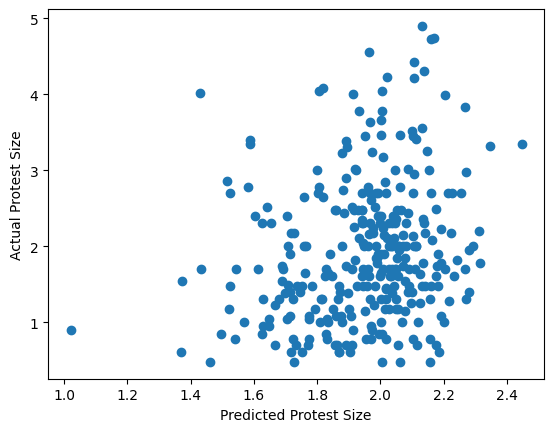

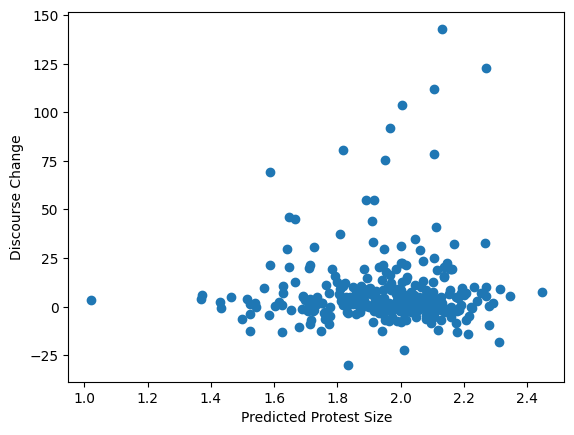

                            OLS Regression Results                            
Dep. Variable:       discourse_change   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6301
Date:                Mon, 15 May 2023   Prob (F-statistic):              0.428
Time:                        19:13:15   Log-Likelihood:                -1356.2
No. Observations:                 309   AIC:                             2716.
Df Residuals:                     307   BIC:                             2724.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.1442     11.088     -0.

In [ ]:
# use 2SLS to estimate the causal effect of protest size on discourse change

# 1st stage: regress protest size on weather
X = instr
y = endog
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
endog_pred = results.predict(X)
endog_pred.name = "size_predicted"

# plot predicted protest size against actual protest size
import matplotlib.pyplot as plt

plt.scatter(endog_pred, y)
plt.xlabel("Predicted Protest Size")
plt.ylabel("Actual Protest Size")
plt.show()

# plot predicted protest size against discourse change
plt.scatter(endog_pred, dep)
plt.xlabel("Predicted Protest Size")
plt.ylabel("Discourse Change")
plt.show()

# 2nd stage: regress discourse change on predicted protest size
X = endog_pred
y = dep
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

### 2SLS with exog

                            OLS Regression Results                            
Dep. Variable:                   size   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     8.540
Date:                Mon, 15 May 2023   Prob (F-statistic):           1.07e-23
Time:                        19:13:15   Log-Likelihood:                -321.08
No. Observations:                 309   AIC:                             698.2
Df Residuals:                     281   BIC:                             802.7
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

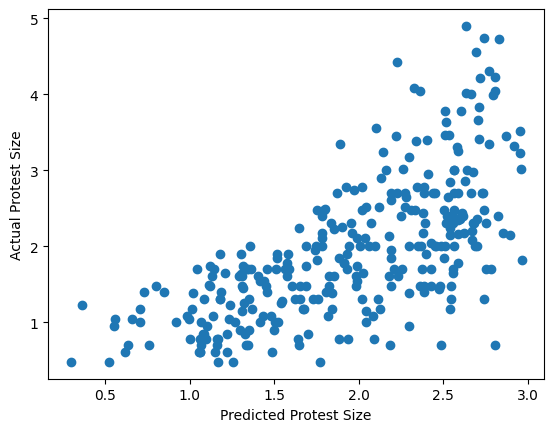

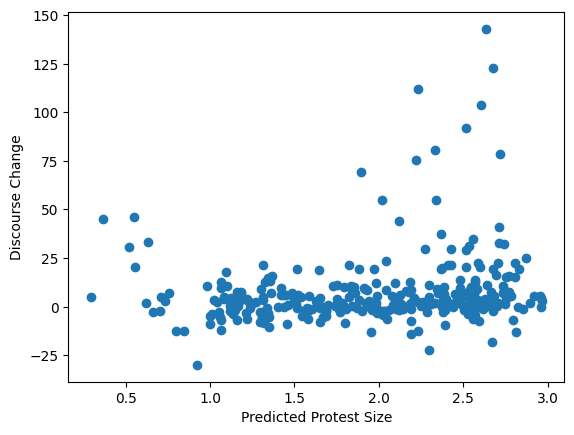

                            OLS Regression Results                            
Dep. Variable:       discourse_change   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     2.924
Date:                Mon, 15 May 2023   Prob (F-statistic):           8.43e-05
Time:                        19:13:15   Log-Likelihood:                -1330.7
No. Observations:                 309   AIC:                             2699.
Df Residuals:                     290   BIC:                             2770.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [ ]:
# use 2SLS to estimate the causal effect of protest size on discourse change

# 1st stage: regress protest size on weather
X = pd.concat([instr, exog], axis=1)
y = endog
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
endog_pred = results.predict(X)
endog_pred.name = "size_predicted"

# plot predicted protest size against actual protest size
import matplotlib.pyplot as plt

plt.scatter(endog_pred, y)
plt.xlabel("Predicted Protest Size")
plt.ylabel("Actual Protest Size")
plt.show()

# plot predicted protest size against discourse change
plt.scatter(endog_pred, dep)
plt.xlabel("Predicted Protest Size")
plt.ylabel("Discourse Change")
plt.show()

# 2nd stage: regress discourse change on predicted protest size
X = pd.concat([endog_pred, exog], axis=1)
y = dep
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

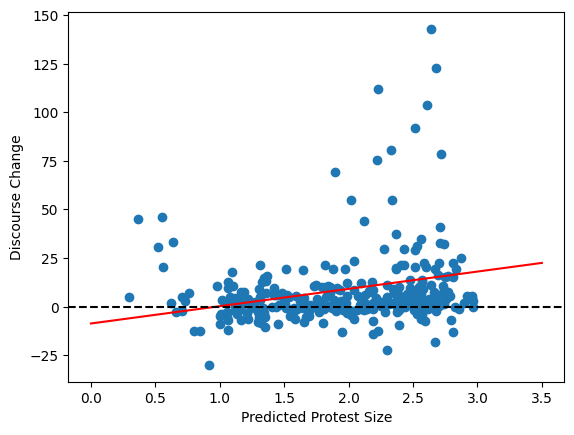

In [ ]:
# plot predicted size against discourse change
plt.scatter(endog_pred, dep)
# plot regression line
intercept = results.params["const"]
slope = results.params["size_predicted"]
x = np.linspace(0, 3.5, 100)
y = intercept + slope * x
plt.plot(x, y, color="red")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Predicted Protest Size")
plt.ylabel("Discourse Change")
plt.show()

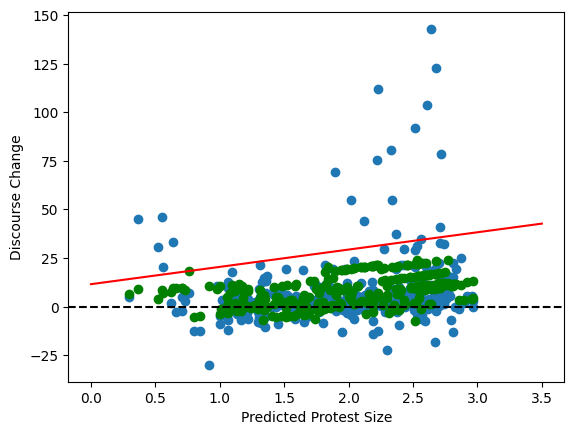

In [ ]:
exog = protests[["admin1", "assoc_actor_1", "weekday"]]
exog = pd.get_dummies(
    exog, columns=["admin1", "assoc_actor_1", "weekday"], drop_first=True
)
# 1st stage: regress protest size on weather
X = pd.concat([instr, exog], axis=1)
y = endog
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
endog_pred = results.predict(X)
endog_pred.name = "size_predicted"
# 2nd stage: regress discourse change on predicted protest size
X = pd.concat([endog_pred, exog], axis=1)
y = dep
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
# plot predicted size against discourse change
plt.scatter(endog_pred, dep)
# plot predicted size against predicted discourse change (?)
plt.scatter(endog_pred, results.predict(), color="green")
# plot regression line
intercept = results.params["const"]
slope = results.params["size_predicted"]
x = np.linspace(0, 3.5, 100)
y = intercept + slope * x
plt.plot(x, y, color="red")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Predicted Protest Size")
plt.ylabel("Discourse Change")
plt.show()

👀

## liblinear 2SLS

In [ ]:
from linearmodels.iv.model import IV2SLS

iv = IV2SLS(dependent=dep, exog=np.ones(len(dep)), endog=endog, instruments=instr)
results = iv.fit()
print(results.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:       discourse_change   R-squared:                      0.1330
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1302
No. Observations:                 309   F-statistic:                    0.7214
Date:                Mon, May 15 2023   P-value (F-stat)                0.3957
Time:                        19:13:15   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog          -1.1442     10.026    -0.1141     0.9091     -20.794      18.506
size           4.4945     5.2918     0.8493     0.39

In [ ]:
exog["const"] = 1
iv = IV2SLS(dependent=dep, exog=exog, endog=endog, instruments=instr)
results = iv.fit()
print(results.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:       discourse_change   R-squared:                      0.3086
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2657
No. Observations:                 309   F-statistic:                    60.902
Date:                Mon, May 15 2023   P-value (F-stat)                0.0000
Time:                        19:13:16   Distribution:                 chi2(18)
Cov. Estimator:                robust                                         
                                                                              
                                                     Parameter Estimates                                                     
                                                           Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------------------------------

## Covid

In [ ]:
covid_df = pd.read_csv(project_root / "datasets" / "covid" / "owid-covid-data.csv")
covid_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [ ]:
covid_cols = [
    "new_deaths_smoothed_per_million",
    "icu_patients_per_million",
    "new_tests_smoothed_per_thousand",
    "stringency_index",
]
covid_df = covid_df.query("location == 'Germany'").sort_values("date")[
    ["date"] + covid_cols
]
covid_df["date"] = pd.to_datetime(covid_df["date"])
covid_df.set_index("date", inplace=True)
covid_df.tail()

,new_deaths_smoothed_per_million,icu_patients_per_million,new_tests_smoothed_per_thousand,stringency_index
date,,,,
2023-05-10,NaN,4.402,NaN,NaN
2023-05-11,NaN,4.138,NaN,NaN
2023-05-12,NaN,4.066,NaN,NaN
2023-05-13,NaN,4.042,NaN,NaN
2023-05-14,NaN,4.054,NaN,NaN


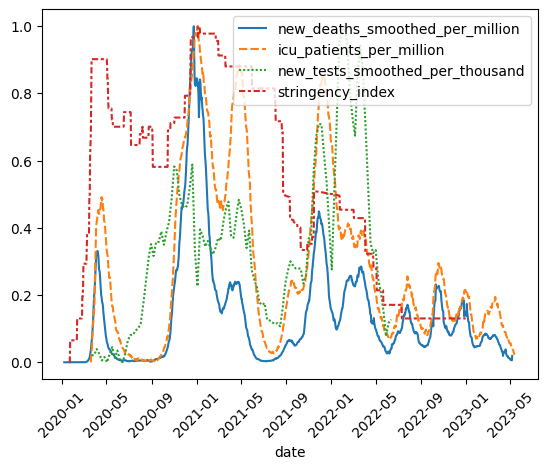

In [ ]:
import seaborn as sns

# min-max normalize all columns
for col in covid_cols:
    covid_df[col] = (covid_df[col] - covid_df[col].min()) / (
        covid_df[col].max() - covid_df[col].min()
    )

# plot all time series in one plot
sns.lineplot(data=covid_df[covid_cols])
# rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

In [ ]:
for col in covid_cols:
    print(col, covid_df[col].isna().sum())
    covid_df[col] = covid_df[col].fillna(0)

new_deaths_smoothed_per_million 13
icu_patients_per_million 77
new_tests_smoothed_per_thousand 415
stringency_index 153


In [ ]:
endog = protests["size"]
exog = protests[["admin1", "assoc_actor_1", "weekday"]]
exog = pd.get_dummies(
    exog, columns=["admin1", "assoc_actor_1", "weekday"], drop_first=True
)
exog["const"] = 1
instr = protests[covid_cols]
dep = protests["discourse_change"]

In [ ]:
iv = IV2SLS(dependent=dep, exog=np.ones(len(exog)), endog=endog, instruments=instr)
results = iv.fit()
print(results.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:       discourse_change   R-squared:                      0.0164
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0132
No. Observations:                 308   F-statistic:                    7.0843
Date:                Tue, May 16 2023   P-value (F-stat)                0.0078
Time:                        11:21:02   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog           3.6646     1.2083     3.0329     0.0024      1.2964      6.0328
size           0.0026     0.0010     2.6616     0.00

Inputs contain missing values. Dropping rows with missing observations.


In [ ]:
iv = IV2SLS(dependent=dep, exog=exog, endog=endog, instruments=instr)
results = iv.fit()
print(results.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:       discourse_change   R-squared:                      0.1118
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0565
No. Observations:                 308   F-statistic:                    70.661
Date:                Tue, May 16 2023   P-value (F-stat)                0.0000
Time:                        11:21:02   Distribution:                 chi2(18)
Cov. Estimator:                robust                                         
                                                                              
                                                     Parameter Estimates                                                     
                                                           Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------------------------------

Inputs contain missing values. Dropping rows with missing observations.


In [ ]:
_endog = (
    pd.get_dummies(protests["assoc_actor_1"])
    .multiply(endog, axis="index")
    .rename(lambda x: "size_" + x, axis="columns")
)

In [ ]:
iv = IV2SLS(dependent=dep, exog=exog, endog=_endog, instruments=instr)
results = iv.fit()
print(results.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:       discourse_change   R-squared:                     -3.9683
Estimator:                    IV-2SLS   Adj. R-squared:                -4.3145
No. Observations:                 308   F-statistic:                    30.854
Date:                Tue, May 16 2023   P-value (F-stat)                0.0571
Time:                        11:21:04   Distribution:                 chi2(20)
Cov. Estimator:                robust                                         
                                                                              
                                                     Parameter Estimates                                                     
                                                           Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------------------------------

Inputs contain missing values. Dropping rows with missing observations.


In [ ]:
results.wooldridge_overid

Wooldridge's score test of overidentification
H0: Model is not overidentified.
Statistic: 0.5484
P-value: 0.4590
Distributed: chi2(1)
WaldTestStatistic, id: 0x2f41cee00

In [ ]:
results.wooldridge_regression

Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 4.0938
P-value: 0.2515
Distributed: chi2(3)
WaldTestStatistic, id: 0x2f41cf2e0

In [ ]:
results.wooldridge_score

Wooldridge's score test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 3.7677
P-value: 0.2877
Distributed: chi2(3)
WaldTestStatistic, id: 0x2f41cffa0

In [ ]:
from linearmodels.iv.model import IVLIML

iv = IVLIML(dependent=dep, exog=exog, endog=endog, instruments=instr)
results = iv.fit()
print(results.summary)

                          IV-LIML Estimation Summary                          
Dep. Variable:       discourse_change   R-squared:                     -0.2209
Estimator:                    IV-LIML   Adj. R-squared:                -0.2970
No. Observations:                 308   F-statistic:                    66.233
Date:                Tue, May 16 2023   P-value (F-stat)                0.0000
Time:                        11:21:15   Distribution:                 chi2(18)
Cov. Estimator:                robust                                         
                                                                              
                                                     Parameter Estimates                                                     
                                                           Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------------------------------

Inputs contain missing values. Dropping rows with missing observations.


In [ ]:
from linearmodels.iv.model import IVGMM

iv = IVGMM(dependent=dep, exog=exog, endog=endog, instruments=instr)
results = iv.fit()
print(results.summary)

                          IV-GMM Estimation Summary                           
Dep. Variable:       discourse_change   R-squared:                      0.0825
Estimator:                     IV-GMM   Adj. R-squared:                 0.0253
No. Observations:                 308   F-statistic:                    68.269
Date:                Tue, May 16 2023   P-value (F-stat)                0.0000
Time:                        13:36:22   Distribution:                 chi2(18)
Cov. Estimator:                robust                                         
                                                                              
                                                     Parameter Estimates                                                     
                                                           Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------------------------------

Inputs contain missing values. Dropping rows with missing observations.
